# Finding Lane Lines for Self Driving Cars

This talk will walk through identifying lane lines based on images and video taken from onboard cameras.

### Packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

%matplotlib inline

# Camera Calibration

Create a list for the object points, and image points.
Loop through all the calibration images, when we find chessboard corners we add those image points and object points to the lists and do it again.

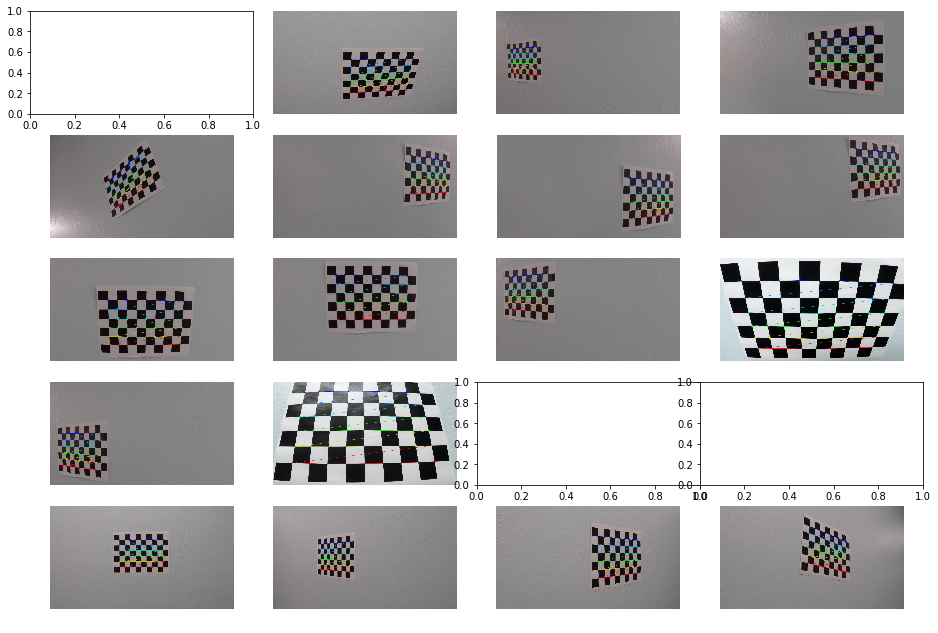

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list of images and search for chessboard corners in each one
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points to the lists
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        axs[i].axis('off')
        axs[i].imshow(img)

*** Note that some of the images do not show because the chessboard corners were not found (ret == False).

### Use the object and image point lists from the chessboards above to calibrate the camera

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

What do these things look like, anyway?

In [4]:
print("Camera Matrix")
print(mtx)
print("Distortion Coeffs")
print(dist)

Camera Matrix
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Distortion Coeffs
[[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


# Image Distortion Correction

We can use the `cv2.undistort` function to undistort our images based on our camera calibration from above

Here's a helper function to do just that:

In [5]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

Let's test it out on one of the chessboard images and see what it looks like after it's undistorted

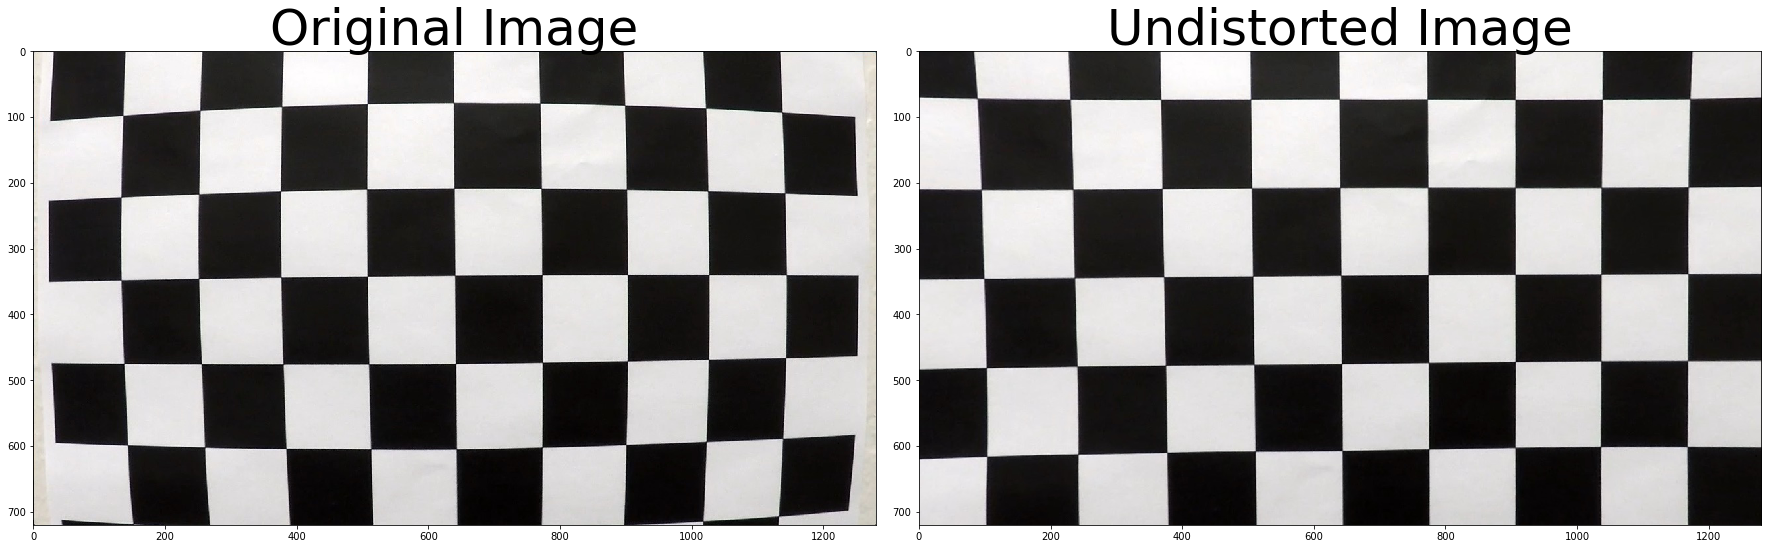

In [6]:
fname = './camera_cal/calibration1.jpg'

img = mpimg.imread(fname)

# Use the undistort function, with the mtx and dist calculated above
undist = undistort(img, mtx, dist)

### print an example plot of a comparison of a distorted and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Well you can definitely see a difference! And the lines seem pretty straight to me.

Let's try it on an image taken from a car video.

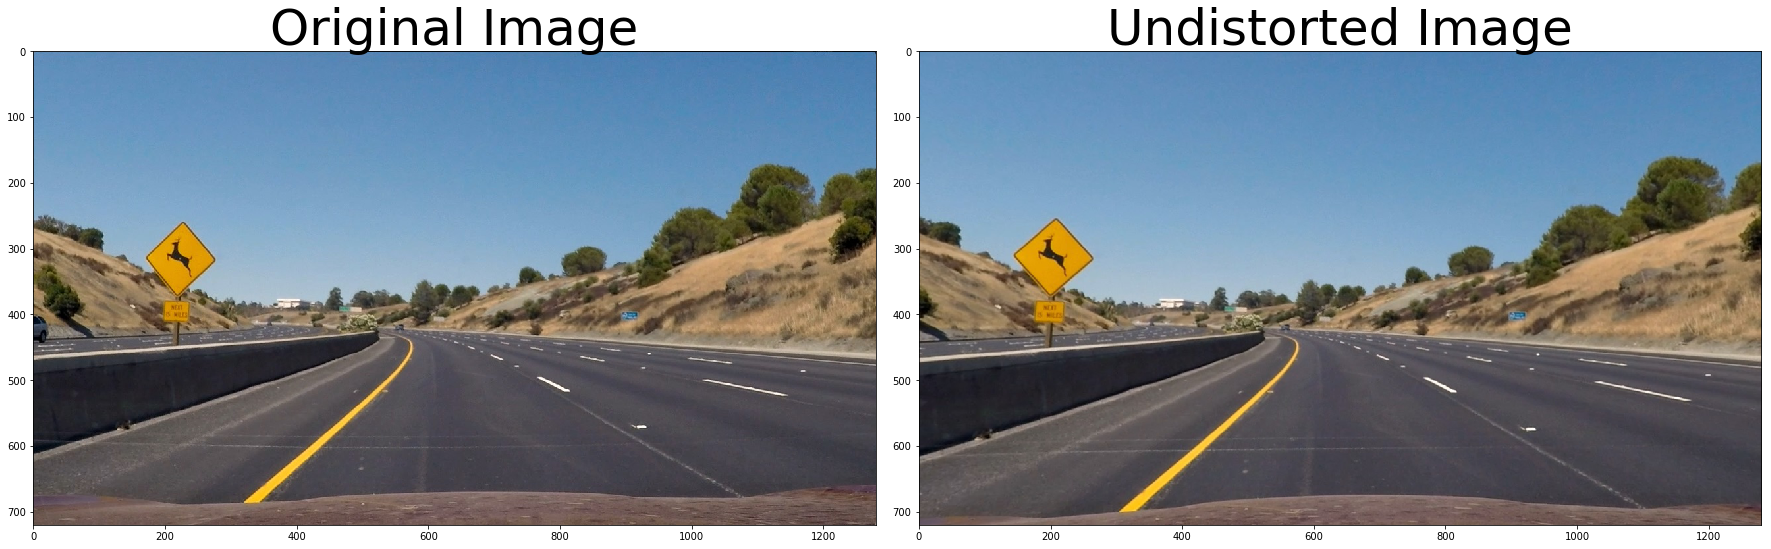

In [7]:
fname = './test_images/test2.jpg'

img = mpimg.imread(fname)

# Use the undistort function, with the mtx and dist calculated above
undist = undistort(img, mtx, dist)

### print an example plot of a comparison of a distorted and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Perspective Transform

In [8]:
def add_points(img, src):
    img2 = np.copy(img)
    color = [255, 0, 0] # Red
    thickness = -1
    radius = 15
    x0, y0 = src[0]
    x1, y1 = src[1]
    x2, y2 = src[2]
    x3, y3 = src[3]
    cv2.circle(img2, (x0, y0), radius, color, thickness)
    cv2.circle(img2, (x1, y1), radius, color, thickness)
    cv2.circle(img2, (x2, y2), radius, color, thickness)
    cv2.circle(img2, (x3, y3), radius, color, thickness)
    return img2

def add_lines(img, src):
    img2 = np.copy(img)
    color = [255, 0, 0] # Red
    thickness = 2
    x0, y0 = src[0]
    x1, y1 = src[1]
    x2, y2 = src[2]
    x3, y3 = src[3]
    cv2.line(img2, (x0, y0), (x1, y1), color, thickness)
    cv2.line(img2, (x1, y1), (x2, y2), color, thickness)
    cv2.line(img2, (x2, y2), (x3, y3), color, thickness)
    cv2.line(img2, (x3, y3), (x0, y0), color, thickness)
    return img2

In [9]:
# Source Points
src = np.float32([
    [150, 720],
    [590, 450], 
    [690, 450], 
    [1150, 720]
])

# Destination Points
dst = np.float32([
    [250, 720],
    [250, 0], 
    [1035, 0], 
    [1035, 720]
])

def warper(img):
    
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img):
    
    # Compute and apply inverse perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)
    
    return unwarped

### Test these functions on pictures with straight lane lines

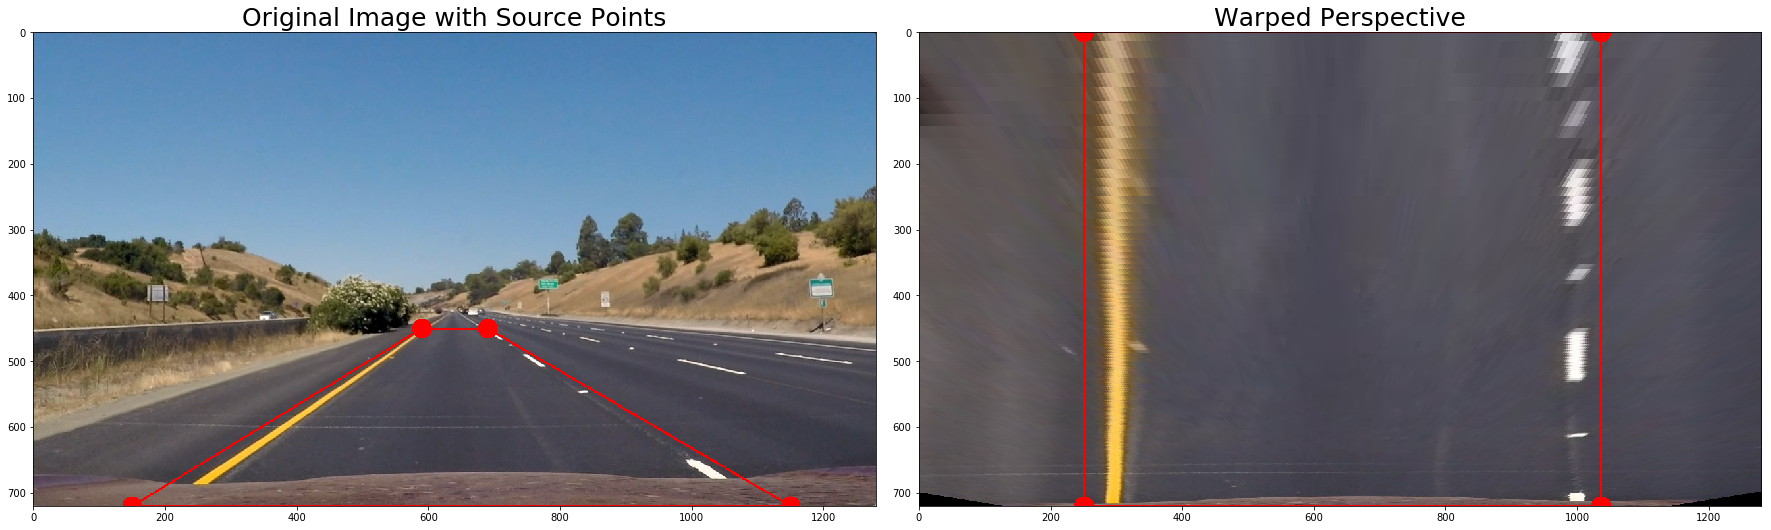

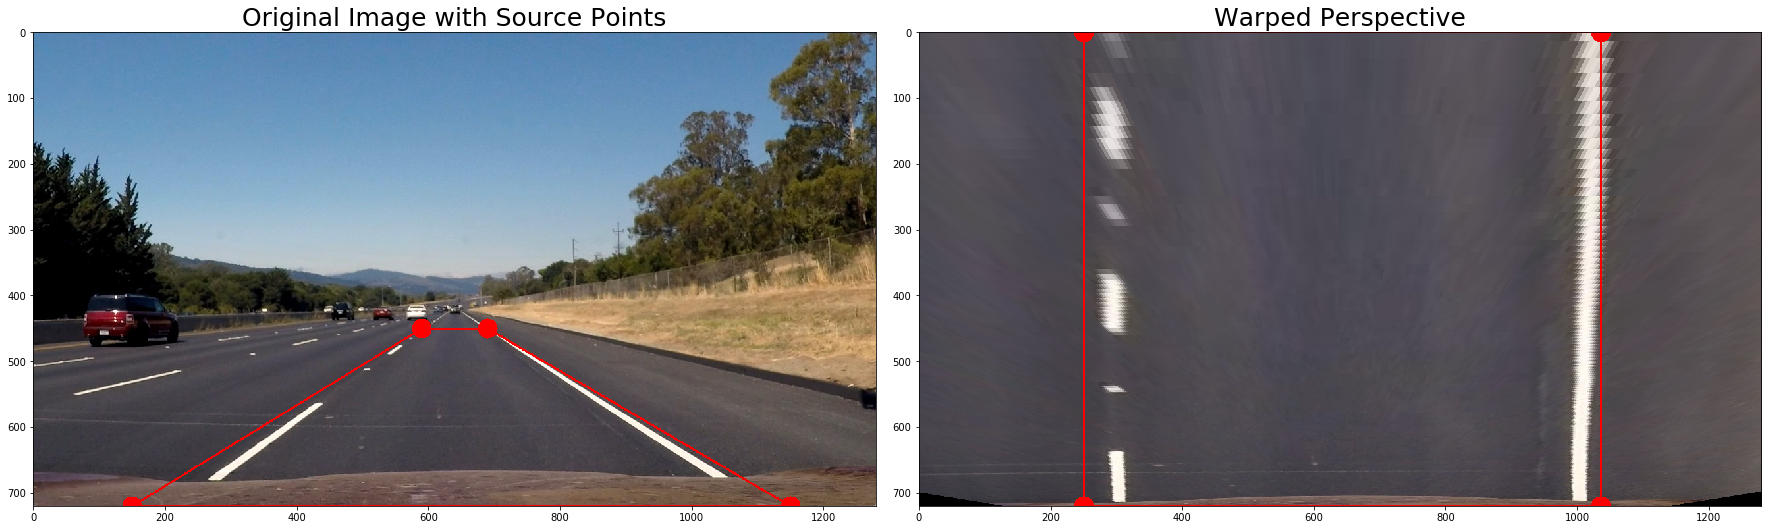

In [10]:
### get the straight test images from the test_images folder
images = glob.glob('./test_images/straight*.jpg')

for fname in images:
    
    img = mpimg.imread(fname)
    
    # Undistort the image based on the camera calibration
    undist = undistort(img, mtx, dist)
    
    # warp the image
    warped = warper(undist)

    # add the points to the og and warped images 
    src_points_img = add_points(img, src)
    src_points_img = add_lines(src_points_img, src)
    dst_points_warped = add_points(warped, dst)
    dst_points_warped = add_lines(dst_points_warped, dst)

    ### Plot the source points on the original image and the warped image
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(src_points_img)
    ax1.set_title('Original Image with Source Points', fontsize=25)
    ax2.imshow(dst_points_warped)
    ax2.set_title('Warped Perspective', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


TH